In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
from statsmodels.tools.eval_measures import rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


In [42]:
df = pd.read_csv('uber.csv')

In [43]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [44]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [45]:
df.shape

(200000, 9)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Data Pre Processing

In [47]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [48]:
df1 = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [49]:
df.drop(df1, inplace=True, errors="ignore")

In [50]:
df1.shape

(12, 9)

In [51]:
#changing the incorrect data type
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [52]:
df1.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [53]:
# we will extract time feature from the 'pickup_datetime' 
# we will add a variable which measures the distance between pickup and drop

df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)

Haversine Formula

In [54]:
from math import *

In [55]:
def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist

In [56]:
df['dist_travel_km'] = distance_transform(df['pickup_longitude'].to_numpy(),
                                                df['pickup_latitude'].to_numpy(),
                                                df['dropoff_longitude'].to_numpy(),
                                                df['dropoff_latitude'].to_numpy()
                                              )

In [57]:
df = df.drop('pickup_datetime',axis=1)

In [58]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,200000.0,2.771250e+07,1.601382e+07,1.000000,1.382535e+07,2.774550e+07,4.155530e+07,5.542357e+07
fare_amount,200000.0,1.135996e+01,9.901776e+00,-52.000000,6.000000e+00,8.500000e+00,1.250000e+01,4.990000e+02
pickup_longitude,200000.0,-7.252764e+01,1.143779e+01,-1340.648410,-7.399206e+01,-7.398182e+01,-7.396715e+01,5.741846e+01
pickup_latitude,200000.0,3.993589e+01,7.720539e+00,-74.015515,4.073480e+01,4.075259e+01,4.076716e+01,1.644421e+03
dropoff_longitude,199999.0,-7.252529e+01,1.311741e+01,-3356.666300,-7.399141e+01,-7.398009e+01,-7.396366e+01,1.153573e+03
dropoff_latitude,199999.0,3.992389e+01,6.794829e+00,-881.985513,4.073382e+01,4.075304e+01,4.076800e+01,8.726976e+02
passenger_count,200000.0,1.684535e+00,1.385997e+00,0.000000,1.000000e+00,1.000000e+00,2.000000e+00,2.080000e+02
hour,200000.0,1.349133e+01,6.515531e+00,0.000000,9.000000e+00,1.400000e+01,1.900000e+01,2.300000e+01
day,200000.0,1.570467e+01,8.687409e+00,1.000000,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
month,200000.0,6.281795e+00,3.438925e+00,1.000000,3.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01


In [59]:
df.columns[df.dtypes == 'object']

Index(['key'], dtype='object')

Identifying Outliers

In [60]:
df.fare_amount.min()

-52.0

Text(0, 0.5, 'fare_amount')

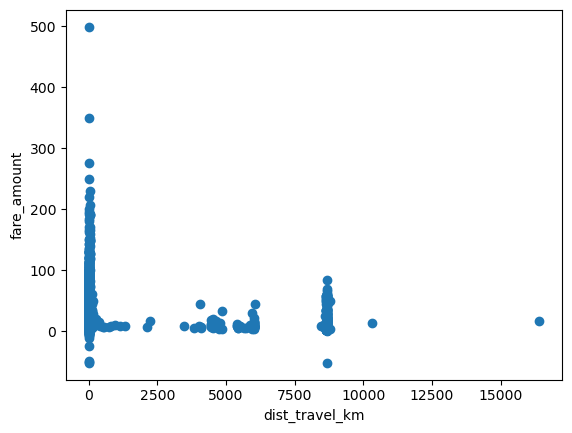

In [61]:
plt.scatter(df['dist_travel_km'], df['fare_amount'])
plt.xlabel('dist_travel_km')
plt.ylabel('fare_amount')

<AxesSubplot:>

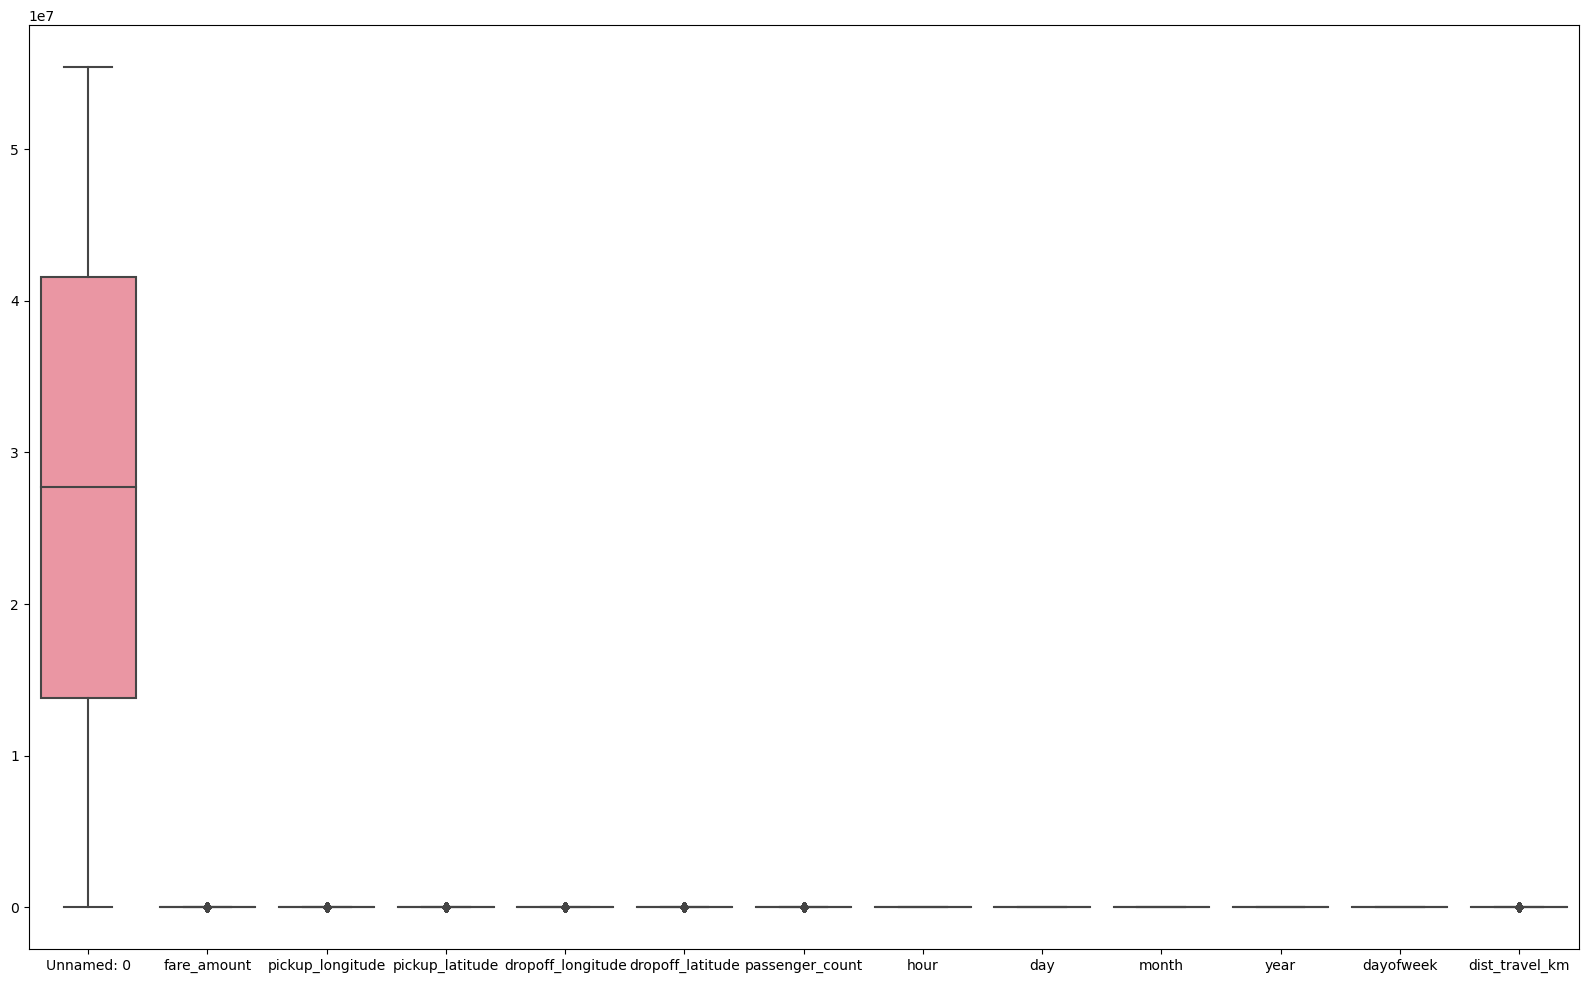

In [62]:
plt.figure(figsize=(20,12))
sns.boxplot(data= df)

In [88]:
# outliers detection using boxplot
plt.figure(figsize =(20, 30))

for i , variable in enumerate(numeric_column):
    plt.subplot(6 , 5, i +1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)
    
plt.show()

NameError: name 'numeric_column' is not defined

<Figure size 2000x3000 with 0 Axes>

In [64]:
df.shape

(200000, 14)

In [65]:
#We will only keep the observation where fare is between 2.5
df = df.loc[(df.fare_amount >= 0)]

In [66]:
df.shape

(199983, 14)

In [67]:
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [68]:
#We will only keep the observation where travel distance is less than or equal to 130
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

Remaining observastions in the dataset: (199982, 14)


Heat Map

In [69]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

In [70]:
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [71]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,24238194,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,7,5,2015,3,1.683323
1,27835199,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,17,7,2009,4,2.457590
2,44984355,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,24,8,2009,0,5.036377
3,25894730,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,26,6,2009,4,1.661683
4,17610152,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,28,8,2014,3,4.475450


In [72]:
Total = df.isnull().sum().sort_values(ascending = False)

Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending = False) 

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    

missing_data['Type'] = df[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
Unnamed: 0,0,0.0,int64
key,0,0.0,object
fare_amount,0,0.0,float64
pickup_longitude,0,0.0,float64
pickup_latitude,0,0.0,float64
dropoff_longitude,0,0.0,float64
dropoff_latitude,0,0.0,float64
passenger_count,0,0.0,int64
hour,0,0.0,int64
day,0,0.0,int64


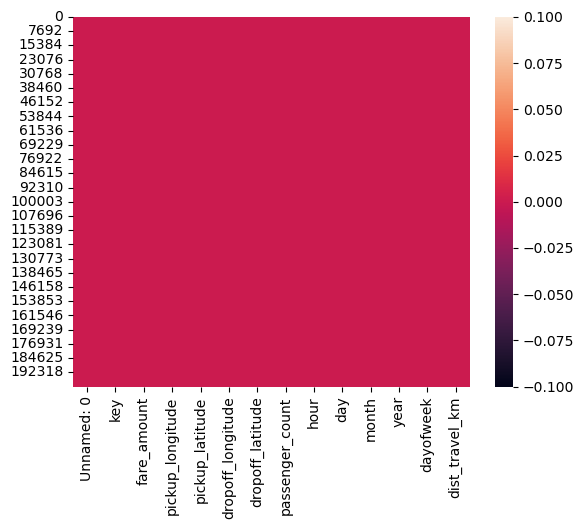

In [73]:
sns.heatmap(df.isnull())
plt.show()

Correlation Matrix

In [74]:
corr = df.corr()
corr


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
Unnamed: 0,1.000000,0.000613,0.000232,-0.000342,0.000296,0.000244,0.002256,0.000038,0.000551,0.001307,-0.001324,-0.004606,-0.000821
fare_amount,0.000613,1.000000,0.010433,-0.008461,0.009145,-0.011183,0.010411,-0.021434,0.001338,0.023595,0.118491,0.007405,0.025443
pickup_longitude,0.000232,0.010433,1.000000,-0.816461,0.833093,-0.846401,-0.000411,0.002433,0.005179,-0.004674,0.009973,0.000822,0.105730
pickup_latitude,-0.000342,-0.008461,-0.816461,1.000000,-0.774849,0.702430,-0.001562,-0.003822,-0.008259,0.004633,-0.010239,-0.002452,-0.062527
dropoff_longitude,0.000296,0.009145,0.833093,-0.774849,1.000000,-0.916997,-0.000031,0.003455,0.005028,-0.003579,0.008424,0.000043,0.056168
dropoff_latitude,0.000244,-0.011183,-0.846401,0.702430,-0.916997,1.000000,-0.000591,-0.002520,-0.007806,0.003790,-0.011194,-0.002380,-0.079388
passenger_count,0.002256,0.010411,-0.000411,-0.001562,-0.000031,-0.000591,1.000000,0.013185,0.003226,0.009813,0.004803,0.033208,-0.001743
hour,0.000038,-0.021434,0.002433,-0.003822,0.003455,-0.002520,0.013185,1.000000,0.004671,-0.003904,0.002140,-0.086943,-0.000734
day,0.000551,0.001338,0.005179,-0.008259,0.005028,-0.007806,0.003226,0.004671,1.000000,-0.017380,-0.012128,0.005616,-0.002213
month,0.001307,0.023595,-0.004674,0.004633,-0.003579,0.003790,0.009813,-0.003904,-0.017380,1.000000,-0.115863,-0.008814,-0.000496


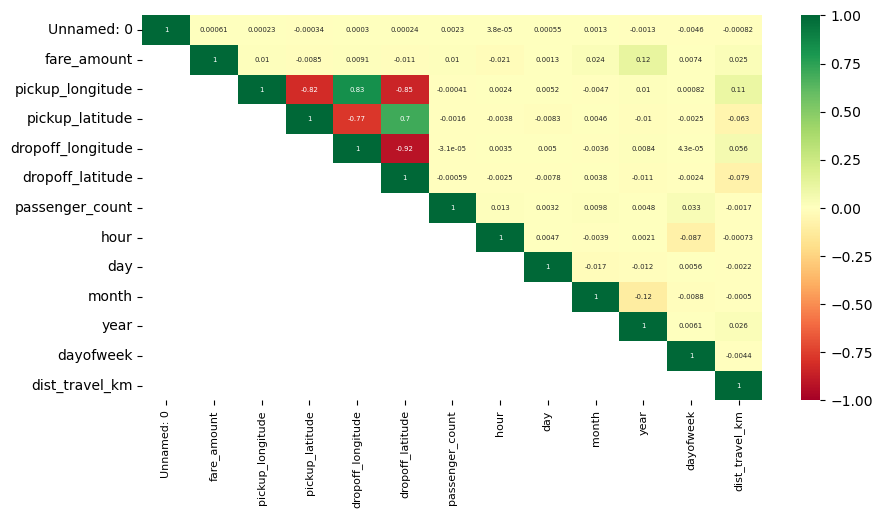

In [75]:
plt.figure(figsize = (10,5))

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k = -1)] = True

sns.heatmap(corr, cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True, annot_kws = {"size": 5}, mask = mask)

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)

plt.show()

Standardization

In [76]:
x=df['dist_travel_km'].values.reshape(-1,1) 
y=df['fare_amount'].values.reshape(-1,1)

In [77]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
y_std = std.fit_transform(y)
print(y_std)
x_std = std.fit_transform(x)
print(x_std)

[[-0.39024668]
 [-0.3700387 ]
 [ 0.15536892]
 ...
 [ 1.97408761]
 [ 0.31703281]
 [ 0.27661684]]
[[-0.05001485]
 [-0.04799058]
 [-0.04124851]
 ...
 [-0.02081945]
 [-0.04516143]
 [-0.04025134]]


Training and Testing Dataset

In [78]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x_std,y_std,test_size=0.2,random_state=0)

Linear Regression: y(fare_amount) is dependent on x(dist_travel_km)

In [79]:
from sklearn.linear_model import LinearRegression
l_reg = LinearRegression()
l_reg.fit(x_train, y_train)

print("Training set score: {: .2f}".format(l_reg.score(x_train, y_train)))
print("Testing set score: {: .7f}".format(l_reg.score(x_train, y_train)))

Training set score:  0.00
Testing set score:  0.0008156


In [80]:
l_reg.coef_

array([[0.028455]])

In [81]:
l_reg.intercept_

array([0.00047722])

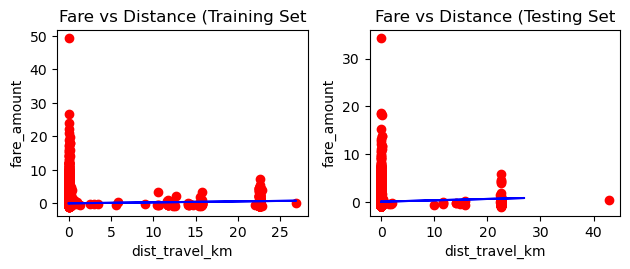

In [83]:
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, color='red')
plt.plot(x_train, l_reg.predict(x_train), color='blue')
plt.title("Fare vs Distance (Training Set")
plt.ylabel("fare_amount")
plt.xlabel("dist_travel_km")

plt.subplot(2, 2, 2)
plt.scatter(x_test, y_test, color='red')
plt.plot(x_train, l_reg.predict(x_train), color='blue')
plt.title("Fare vs Distance (Testing Set")
plt.ylabel("fare_amount")
plt.xlabel("dist_travel_km")

plt.tight_layout()
plt.show()

Predicting Values of y

In [84]:
y_pred = l_reg.predict(x_test)

result = pd.DataFrame()
result[['Actual']] = y_test
result[['Predicted']] = y_pred

result.sample(10)

,Actual,Predicted
36822,0.569633,-0.000638
29281,0.620153,-0.000810
18108,1.748769,-0.000244
9340,0.438281,-0.000563
8008,-0.390247,-0.000926
26547,-0.137647,-0.000953
10827,-0.814614,-0.001005
17307,-0.006295,-0.000897
28720,0.155369,-0.000845
13084,0.064433,-0.000903


In [85]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared:', np.sqrt(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error: 0.6103202010027623
Mean Absolute % Error: 1.004288822635727
Mean Squared Error: 1.0045770088281933
Root Mean Squared Error: 1.0022858917635193
R Squared: nan


C:\Users\saura\AppData\Local\Temp\ipykernel_3792\1482232862.py:5: RuntimeWarning: invalid value encountered in sqrt
  print('R Squared:', np.sqrt(metrics.r2_score(y_test, y_pred)))


In [86]:
cols = ['Model', 'RMSE', 'R-Squared']

result_tabulation = pd.DataFrame(columns = cols)
linreg_metrics = pd.DataFrame([[
    "Linear Regression Model",
    np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
    np.sqrt(metrics.r2_score(y_test, y_pred))
    ]], columns = cols)

result_tabulation = pd.concat([result_tabulation, linreg_metrics], ignore_index = True)

result_tabulation

C:\Users\saura\AppData\Local\Temp\ipykernel_3792\531526522.py:7: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(metrics.r2_score(y_test, y_pred))


,Model,RMSE,R-Squared
0,Linear Regression Model,1.002286,NaN


Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=10)

rf_reg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(random_state=10)

In [ ]:
y_pred_RF = rf_reg.predict(x_test)

result = pd.DataFrame()
result[['Actual']] = y_test
result['Predicted'] = y_pred_RF

result.sample(10)

,Actual,Predicted
39719,-0.188173,-0.203107
39620,-0.693372,-0.552089
19934,-0.248797,-0.530586
17162,-0.572124,-0.350533
5137,-0.036613,0.141106
20626,-0.814619,-0.606253
17963,-0.794412,-0.786497
9302,-0.531708,-0.360090
2375,-0.289213,0.132640
5750,-0.642852,-0.701514


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_RF))
print('Mean Absolute % Error:', metrics.mean_absolute_percentage_error(y_test, y_pred_RF))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_RF))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print('R Squared:', np.sqrt(metrics.r2_score(y_test, y_pred_RF)))

Mean Absolute Error: 0.292256936882393
Mean Absolute % Error: 1.4933662725978671
Mean Squared Error: 0.35782597029481766
Root Mean Squared Error: 0.5981855651006781
R Squared: 0.8038332195242018


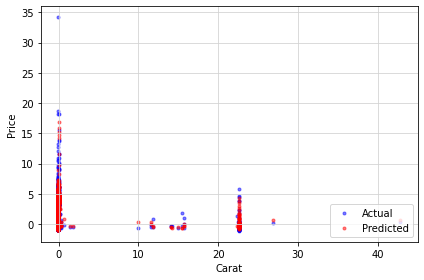

In [ ]:
plt.scatter(x_test, y_test, c='b', alpha= 0.5, marker='.', label='Actual')
plt.scatter(x_test, y_pred_RF, c='r', alpha= 0.5, marker='.', label='Predicted')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

In [ ]:
random_forest = pd.DataFrame([[
    "Random Forest Regression",
    np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)),
    np.sqrt(metrics.r2_score(y_test, y_pred_RF))
    ]], columns = cols)

result_tabulation = pd.concat([result_tabulation, random_forest], ignore_index = True)

result_tabulation

,Model,RMSE,R-Squared
0,Linear Regression Model,1.005570,0.007670
1,Random Forest Regression,0.598186,0.803833
